### **Set Up**

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from prettytable import PrettyTable
import os

Read Dataset

In [4]:
# Path to dataset 
path = "/Users/youhorng/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2"
filename = "Reviews.csv"

# Load the dataset
df = pd.read_csv(os.path.join(path, filename))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Dataset Information

In [5]:
# Check for basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
# Shape of the dataset
print(f"Number of data points: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of data points: 568454
Number of columns: 10


In [7]:
# Check for missing values 
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
# Check for duplication
df.duplicated().sum()

0

In [9]:
# Check for descriptive statistics
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [10]:
# Descriptive statistics for categorical columns
df.describe(include=['object'])

,ProductId,UserId,ProfileName,Summary,Text
count,568454,568454,568428,568427,568454
unique,74258,256059,218415,295742,393579
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",Delicious!,"This review will make me sound really stupid, ..."
freq,913,448,451,2462,199


**Inference**: Based on the information about the **Amazon Fine Food Reviews** dataset above, we have found that:

- There are 568,454 reviews in the dataset with 74,258 products. 

- There are 256,059 users who reviewed on the platform. 

- There are 10 features including the rating score from 1 to 5. 

- There is no duplication but with missing values in 2 columns:

    - There are 26 missing values in `ProfileName`.

    - There are 27 missing values in `Summary`.

### **Exploratory Data Analysis**

Check Missing Values

In [11]:
# ProfileName missing values
df[df["ProfileName"].isnull()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10616,10617,B002DHN956,A1LSYR30XW7CFT,NaN,1,2,5,1291680000,Awesome,This is 72 for the price of like 24 at the gro...
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
47923,47924,B004SRH2B6,A2DEHJJIEAPPBF,NaN,0,0,5,1338940800,Great taste,Enjoy drinking this brand. Tastes as good as ...
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it..."
121819,121820,B006N3I2SK,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
125452,125453,B001EO6ESS,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
137613,137614,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...


**Inference**: According to the rows with `ProfileName` as NaN, we can see that there is no pattern here, and the `UserId` is still available. So, nothing extraordinary here. 

In [12]:
# Summary missing values
df[df["Summary"].isnull()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
155712,155713,B0009VO58S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
178290,178291,B00073IVAQ,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
198474,198475,B000FVBYCW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
212691,212692,B00020HHAO,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
237565,237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,1328572800,NaN,This is a cool system only problem is that the...


**Inference**: Based on the dataframe above, we can see that everything except `ProductId` is the same. 

- This might be due to one product (like a protein bar) can have multiple variants (flavors, sizes).

- With each variant is given a different `ProductId`. 

- So, if a user writes a review for one variant, Amazon sometimes duplicates that reviews across all similar variants. 

Review Scores Distribution

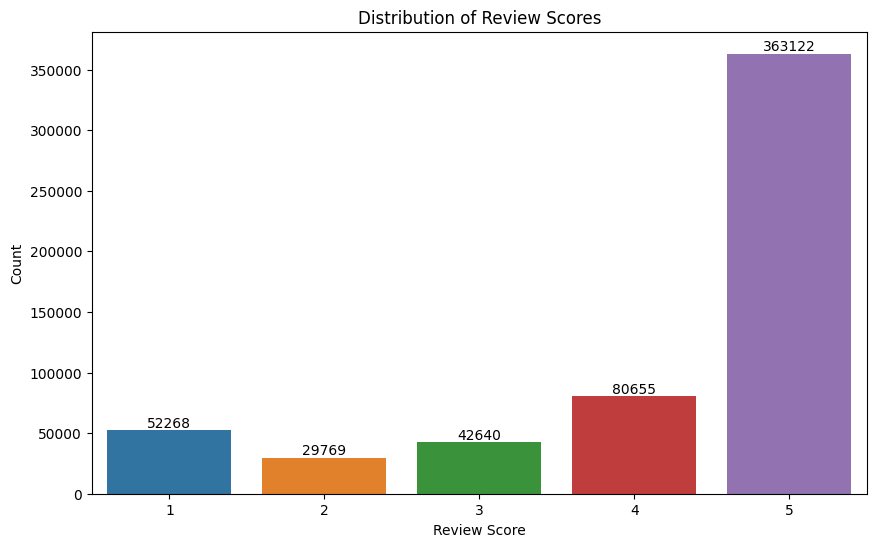

In [13]:
# Plot the distribution of review scores
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="Score")

# Data label
for container in ax.containers:
    ax.bar_label(container)

plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

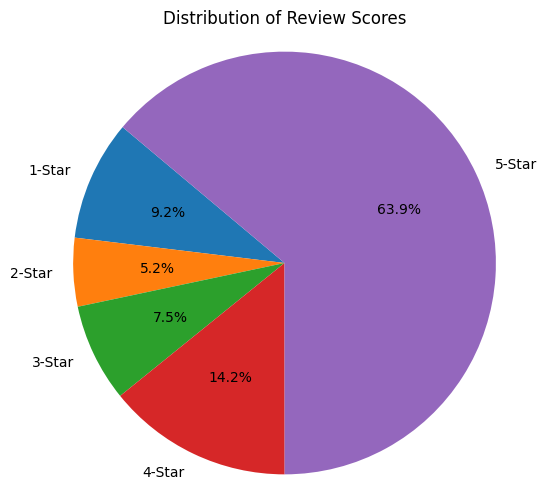

In [14]:
# Count score frequencies
score_counts = df['Score'].value_counts().sort_index()

# Define labels and sizes
labels = [f'{score}-Star' for score in score_counts.index]
sizes = score_counts.values.astype(float)  #

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Review Scores")
plt.axis("equal")  
plt.show()

**Inference**: According the distribution of the rating score above, we have found that:

- **63.9%** of the rating score is  5 star, indicating that most of the products got good review.

- **14.2%** of the rating score is 4 star, following by a 1 star with **9.2%**

### **Data Cleaning**

Check and Delete Duplicate Reviews

In [15]:
# Find the duplate reviews in specific subset
duplicated_reviews = df.duplicated(subset=["UserId", "Time", "Text"], keep="first")
count_duplicated_reviews = np.round(duplicated_reviews.value_counts() / len(df) * 100, 2)

# Create a table to display the results
table = PrettyTable()
table.field_names = ["", "Duplicated Reviews (%)"]
table.add_row(["Yes", count_duplicated_reviews[True]])
table.add_row(["No", count_duplicated_reviews[False]])
print(table)


+-----+------------------------+
|     | Duplicated Reviews (%) |
+-----+------------------------+
| Yes |         30.71          |
|  No |         69.29          |
+-----+------------------------+


**Inference**: We have found that nearly 31% of total reviews are duplicated across product variants. 

- They are the reviews that have the same user with the same text. 

- If we keep these duplications, it will introduce bias into the dataset as there is no meaningful pattern here.

In [16]:
# Remove the duplicated rows 
df = df[~duplicated_reviews]

# Check the shape of the dataset after removing duplicates
print(f"Number of data points after removing duplicates: {df.shape[0]}")

Number of data points after removing duplicates: 393892
